In this module, we make the Markov chain approximation for the Markovian inflow energy $X_t$. The generator function obtained in TS.py is used to train the Markov chain.

In [1]:
import pandas
import numpy
from msppy.utils.plot import fan_plot
from msppy.discretize import Markovian
import matplotlib.pyplot as plt
gamma = numpy.array(pandas.read_csv(
    "./data/gamma.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
sigma = [
    numpy.array(pandas.read_csv(
        "./data/sigma_{}.csv".format(i),
        names=[0,1,2,3],
        index_col=0,
        skiprows=1,
    )) for i in range(12)
]
exp_mu = numpy.array(pandas.read_csv(
    "./data/exp_mu.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
inflow_initial = numpy.array([41248.7153,7386.860854,10124.56146,6123.808537])
T = 12
def generator(random_state,size):
    inflow = numpy.empty([size,T,4])
    inflow[:,0,:] = inflow_initial[numpy.newaxis:,]
    for t in range(1,T):
        noise = numpy.exp(random_state.multivariate_normal(mean=[0]*4, cov=sigma[t%12],size=size))
        inflow[:,t,:] = noise * (
            (1-gamma[t%12]) * exp_mu[t%12]
            + gamma[t%12] * exp_mu[t%12]/exp_mu[(t-1)%12] * inflow[:,t-1,:]
        )
    return inflow

Use robust stochastic approximation to iteratively train a non-homogenuous four-dimensional Markov chain with one initial Markov states and one hundred Markov states from stage two on. We make 1000 iterations to train the Markov states and then 10000 iterations to train the transition matrix.
Refer to:


In [2]:
markovian = Markovian(
    f=generator, 
    T=T, 
    n_Markov_states=[1]+[12]*(T-1), 
    n_sample_paths=1000)
Markov_states, transition_matrix = markovian.SA()

In [3]:
s = generator(numpy.random,100)

In [4]:
pandas.DataFrame(Markov_states[1]).head()

,0,1,2,3
0,28725.903100,11147.475331,6043.028014,6760.707480
1,30723.466819,11666.647339,4517.810059,5644.491189
2,32410.625437,16295.825474,7056.132399,11439.984046
3,36970.896447,11918.623344,7606.999604,7393.424146
4,40398.855634,9240.534704,9636.283242,9921.188432


In [5]:
markovian.Markov_states[1]

array([[28725.90309988, 11147.4753309 ,  6043.02801438,  6760.70748043],
       [30723.46681876, 11666.64733871,  4517.81005855,  5644.49118874],
       [32410.62543724, 16295.82547431,  7056.13239946, 11439.98404584],
       [36970.89644713, 11918.62334404,  7606.999604  ,  7393.42414555],
       [40398.85563409,  9240.53470351,  9636.28324213,  9921.18843201],
       [44260.06157683, 20070.84813457,  9994.23188097, 10542.94214584],
       [47420.45890389,  4556.79336304,  8465.52086532,  8972.37066657],
       [50552.36128619, 16359.25815749, 10409.6415255 ,  9692.9649906 ],
       [50580.42634834,  8244.83510705, 12184.57827442, 12964.67693577],
       [61061.05525964,  6613.87333455, 10332.94745089, 11105.11650989],
       [63637.17095118,  4614.68978039, 25180.47050468, 15969.54704098],
       [68184.61688717,  4653.75933086, 10075.13375449, 12688.92832471]])

In [6]:
pandas.DataFrame(Markov_states[1]).head()

,0,1,2,3
0,28725.903100,11147.475331,6043.028014,6760.707480
1,30723.466819,11666.647339,4517.810059,5644.491189
2,32410.625437,16295.825474,7056.132399,11439.984046
3,36970.896447,11918.623344,7606.999604,7393.424146
4,40398.855634,9240.534704,9636.283242,9921.188432


In [7]:
pandas.DataFrame(transition_matrix[1])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.029,0.01,0.014,0.066,0.187,0.024,0.129,0.045,0.211,0.138,0.048,0.099


Let us see how do the returned markov_states and transition_matrix look like

In [8]:
# stage 0: The initial four-dimensional inflow
Markov_states[0]

array([[41248.7153  ,  7386.860854, 10124.56146 ,  6123.808537]])

In [9]:
# stage 1: The trained 100 Markov states. Each column is a Markov state.
pandas.DataFrame(Markov_states[1]).head()

,0,1,2,3
0,28725.903100,11147.475331,6043.028014,6760.707480
1,30723.466819,11666.647339,4517.810059,5644.491189
2,32410.625437,16295.825474,7056.132399,11439.984046
3,36970.896447,11918.623344,7606.999604,7393.424146
4,40398.855634,9240.534704,9636.283242,9921.188432


In [10]:
# Stage 0: transition matrix always begins with [[1]] since the first stage is always
# assumed to be deterministic.
transition_matrix[0]

array([[1]])

In [11]:
# stage 1: transition matrix between the initial single Markov state 
# and the 100 Markov states in the second stage, so it is 1 by 100.
pandas.DataFrame(transition_matrix[1])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.029,0.01,0.014,0.066,0.187,0.024,0.129,0.045,0.211,0.138,0.048,0.099


In [12]:
# stage 2: transition matrix between the 100 Markov states in the second stage
# and the 100 Markov states in the third stage, so it is 100 by 100.
pandas.DataFrame(transition_matrix[2]).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.206897,0.000000,0.103448,0.344828,0.034483,0.034483,0.137931,0.068966,0.034483,0.034483,0.000000,0.000000
1,0.200000,0.000000,0.300000,0.200000,0.100000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.285714,0.000000,0.142857,0.142857,0.071429,0.142857,0.071429,0.142857,0.000000,0.000000,0.000000
3,0.060606,0.045455,0.106061,0.196970,0.242424,0.015152,0.045455,0.196970,0.030303,0.030303,0.000000,0.030303
4,0.037433,0.032086,0.026738,0.219251,0.128342,0.016043,0.133690,0.229947,0.064171,0.053476,0.005348,0.053476


Use the trained Markov state space and transition matrix to simulate inflow data. It is clear that the fan plot of the simulated sample path is very similar to that of the historical data (see TS.py).

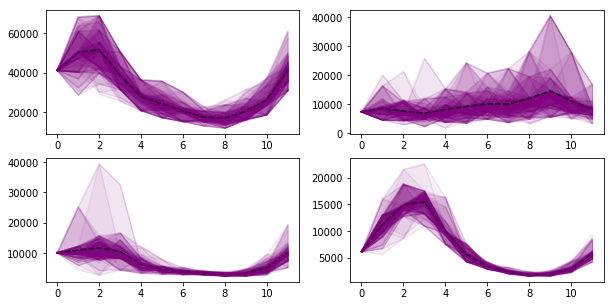

In [13]:
sim = markovian.simulate(100)
fig = plt.figure(figsize=(10,5))
ax = [None] * 4
for i in range(4):
    ax[i] = plt.subplot(221+i)
    fan_plot(pandas.DataFrame(sim[:,:,i]),ax[i])

Let us also try the SAA, SA and RSA approaches to make MC approximation.

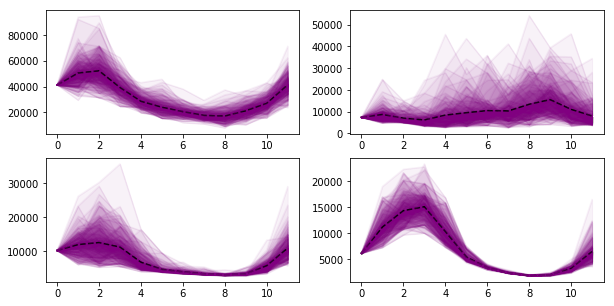

In [14]:
markovian = Markovian(
    f=generator, 
    T=T, 
    n_Markov_states=[1]+[100]*(T-1), 
    n_sample_paths=10000,
)
Markov_states, transition_matrix = markovian.SAA()
fig = plt.figure(figsize=(10,5))
sim = markovian.simulate(100)
ax = [None]*4
for i in range(4):
    ax[i] = plt.subplot(221+i)
    fan_plot(pandas.DataFrame(sim[:,:,i]),ax[i])

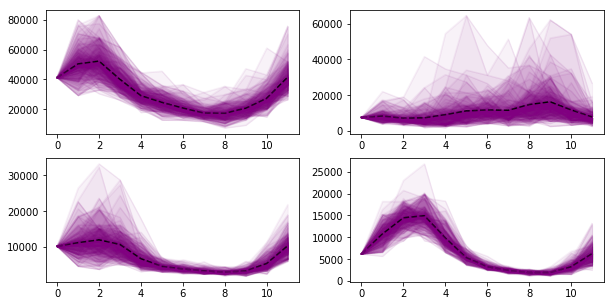

In [15]:
markovian = Markovian(
    f=generator, 
    T=T, 
    n_Markov_states=[1]+[100]*(T-1), 
    n_sample_paths=10000,
)
Markov_states, transition_matrix = markovian.SA()
fig = plt.figure(figsize=(10,5))
sim = markovian.simulate(100)
ax = [None]*4
for i in range(4):
    ax[i] = plt.subplot(221+i)
    fan_plot(pandas.DataFrame(sim[:,:,i]),ax[i])

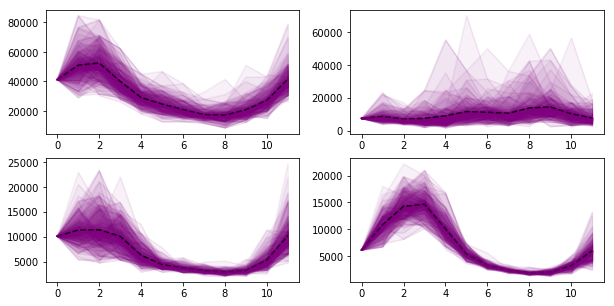

In [16]:
markovian = Markovian(
    f=generator, 
    T=T, 
    n_Markov_states=[1]+[100]*(T-1), 
    n_sample_paths=10000,
)
Markov_states, transition_matrix = markovian.RSA()
fig = plt.figure(figsize=(10,5))
sim = markovian.simulate(100)
ax = [None]*4
for i in range(4):
    ax[i] = plt.subplot(221+i)
    fan_plot(pandas.DataFrame(sim[:,:,i]),ax[i])